In [1]:
import numpy as np
import pathlib
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

In [4]:
input_shape = (631,)
batch_size = 8

cwd = os.getcwd()
x_train_dir = pathlib.Path(cwd + '/data/X_train_631_new.npz')
y_train_dir = pathlib.Path(cwd + '/data/Y_train_195.npz')
x_test_dir  = pathlib.Path(cwd + '/data/X_test_631_new.npz')
y_test_dir  = pathlib.Path(cwd + '/data/Y_test_195.npz')
checkpoint_dir = pathlib.Path('D:./TF_checkpoint/mlp/weight/')
model_dir = pathlib.Path('D:./TF_backup/mlp/mlp7_631.h5')

x_train = np.asarray(np.load(x_train_dir, allow_pickle=True)['arr_0'], dtype=np.float32)
y_train = np.asarray(np.load(y_train_dir, allow_pickle=True)['arr_0'], dtype=np.float32)
x_test = np.asarray(np.load(x_test_dir, allow_pickle=True)['arr_0'], dtype=np.float32)
y_test = np.asarray(np.load(y_test_dir, allow_pickle=True)['arr_0'], dtype=np.float32)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
)

In [5]:
print(np.shape(x_train))

(6720, 631)


In [6]:
normalizer = layers.Normalization()
normalizer.adapt(x_train)

# Define model
input_layer = layers.Input(shape=input_shape)
norm = normalizer(input_layer)
den1 = layers.Dense(1024, activation='relu', kernel_initializer='HeNormal')(norm)
drop1 = layers.Dropout(0.2)(den1)
den2 = layers.Dense(1024, activation='relu', kernel_initializer='HeNormal')(drop1)
drop2 = layers.Dropout(0.2)(den2)
den3 = layers.Dense(1024, activation='relu', kernel_initializer='HeNormal')(drop2)
drop3 = layers.Dropout(0.2)(den3)
den4 = layers.Dense(14, activation='softmax')(drop3)
model = keras.Model(input_layer, den4)

opt = tf.keras.optimizers.SGD(
    learning_rate=0.0001,
    momentum=0.8,
    nesterov=True,
    name='SGD',
)

model.compile(
    optimizer=opt, 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
    )

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 631)]             0         
                                                                 
 normalization (Normalizatio  (None, 631)              1263      
 n)                                                              
                                                                 
 dense (Dense)               (None, 1024)              647168    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                             

In [8]:
epochs = 50
model.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=epochs, callbacks=[model_checkpoint])
model.save(model_dir)

Epoch 1/50
840/840 [==============================] - 5s 5ms/step - loss: 2.7390 - accuracy: 0.1933
Epoch 2/50
840/840 [==============================] - 4s 5ms/step - loss: 1.9472 - accuracy: 0.3647
Epoch 3/50
840/840 [==============================] - 4s 5ms/step - loss: 1.6496 - accuracy: 0.4497
Epoch 4/50
840/840 [==============================] - 4s 5ms/step - loss: 1.4440 - accuracy: 0.5057
Epoch 5/50
840/840 [==============================] - 4s 5ms/step - loss: 1.3242 - accuracy: 0.5457
Epoch 6/50
840/840 [==============================] - 4s 5ms/step - loss: 1.2264 - accuracy: 0.5798
Epoch 7/50
840/840 [==============================] - 4s 5ms/step - loss: 1.1496 - accuracy: 0.6001
Epoch 8/50
840/840 [==============================] - 4s 5ms/step - loss: 1.0852 - accuracy: 0.6228
Epoch 9/50
840/840 [==============================] - 4s 5ms/step - loss: 1.0136 - accuracy: 0.6433
Epoch 10/50
840/840 [==============================] - 4s 5ms/step - loss: 0.9730 - accuracy: 0.6577

In [9]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

53/53 [==============================] - 0s 3ms/step - loss: 0.8107 - accuracy: 0.7452
Test loss: 0.8106610178947449
Test accuracy: 0.7452380657196045


In [13]:
print(np.shape(np.array([x_test])))

(1, 1680, 219)


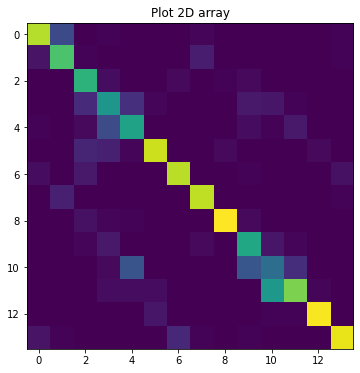

In [15]:
# draw confusion matrix
import sys
def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush() 

i = 0
cmatrix = np.zeros((14,14), dtype=np.int16)
bat = int(len(x_test)/60)
for i in range(0, len(x_test),bat):
    progress(i, 1679)
    result = model.predict_on_batch(x_test[i:i+bat])
    ans = y_test[i:i+bat]
    for j in range(bat):
        id1 = np.argmax(result[j])
        id2 = np.argmax(ans[j])
        cmatrix[id1, id2] = cmatrix[id1][id2] + 1

cmatrix = np.absolute(cmatrix)
# print(repr(cmatrix))

fig = plt.figure(figsize=(6,6))
plt.imshow(cmatrix)
plt.title("Plot 2D array")
plt.show()

Confusion: <br>
flatten vs brittle <br>
plated partially_purple vs plated purple


In [16]:
acc = []
for i in range(14):
    acc.append(np.round(cmatrix[i][i]/120,3))
print(acc)
print(np.mean(acc))

[0.858, 0.692, 0.625, 0.508, 0.558, 0.892, 0.867, 0.875, 0.967, 0.575, 0.35, 0.775, 0.958, 0.933]
0.7452142857142857
